In [1]:
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import Point, Polygon
from typing import Union, Tuple
from util_detroit import first_in_range_camera, csv_with_x_y_to_gpd, get_normalized_time_series

import re,os
import numpy as np
import matplotlib.pyplot as plt

import kml2geojson
import json

pd.options.display.max_columns = None

/Users/ahakso/.virtualenvs/detroit/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## possible changes
Possible change in structure of matched_df: Rather than selecting a single greenlight location based on either nearest (currently) or first (potential change), match each call to _every_ greenlight camera. Then when calculating background rate, use unique calls, but when calculating proportions, count the calls in overlapping radii multiple times

## definite changes
1. Address the fact that the time covered by the two data sets is not the same
  1. There is a complication: if we just drop the greenlight location entirely, we will be treating that area as if there is no green light location, which would obviously not be great. We could drop both the greenlight location and calls that happened in proximity to that location, which would probably be acceptable (results in a roughly 15% reduction in calls in data set)
  1. If we don't want to drop these entirely, we would just have to make sure that the "no call" days are nulls rather than 0s, and are being treated properly

## Things to understand
* Jump in number of calls for days_since_live at 0
* figure out whether or not days without calls for a given camera is being treated properly
* How is the normalization across a camera's history interacting with the different camera populations for a given live date?

### Load data (s3 pull or local read)

In [2]:
bucket = "s3://secondmeasure-dev-at-foundational-data/hakso/detroit/"
greenlight_fn = f"Project_Green_Light_Locations.geojson"
fn_911 = f"911_Calls_For_Service.csv"
fullpath_911 = f"{bucket}{fn_911}"
fullpath_greenlight = f"{bucket}{greenlight_fn}"
nrows = None # None to read all rows
calls = (
    csv_with_x_y_to_gpd(
        #     fullpath,#from s3
        fn_911,  # local
        read_csv_args={
            "nrows": nrows,
            "usecols": [
                "X",
                "Y",
                "incident_id",
                "calldescription",
                "category",
                "call_timestamp",
            ],
        },
    )
    .astype({"call_timestamp": "datetime64"})
    .assign(call_day=lambda df: df.call_timestamp.round("D"))
)

In [92]:
display(calls.head(3))
print(f"{calls.shape[0]/1e6:.2f}M rows")

,geometry,calldescription,category,call_timestamp,call_day
0,POINT (-82.98696 42.40836),DISTURBANCE,DISTURB,2016-09-20 09:36:12,2016-09-20
1,POINT (-83.18521 42.43091),AUTO X UNK INJ / IMPAIRED,ACCUNK,2016-09-20 09:46:32,2016-09-20
2,POINT (-83.14606 42.43877),RECOVER AUTO,RECAUTO,2016-09-20 09:48:24,2016-09-20


4.04M rows


In [3]:
greenlight_geo_df = (
    gpd.read_file(greenlight_fn)
    .astype({"live_date": "datetime64"})
    .assign(live_day=lambda df: df.live_date.round("D"))
)

In [93]:
display(greenlight_geo_df.head(3))
print(f"{greenlight_geo_df.shape[0]:.0f} rows")

,address,business_name,business_type,precinct,live_date,ObjectId,geometry,live_day
0,15510 Fenkell St,Mobil,Retail,8,2016-01-01 05:00:00,1,POINT (-83.19918 42.40172),2016-01-01
1,8930 W McNichols Rd,Marathon,Retail,12,2016-01-01 05:00:00,2,POINT (-83.15984 42.41718),2016-01-01
2,15439 Schoolcraft Ave,Citgo,Retail,2,2016-01-01 05:00:00,3,POINT (-83.19764 42.38679),2016-01-01


767 rows


#### Distance calculation

In [116]:
greenlight_geo_df.head().crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [117]:
greenlight_geo_df.head().to_crs(crs='epsg:3857').crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
combined_df = pd.read_parquet('tmp.parquet')

In [13]:
calls = calls.loc[ :, ["geometry", "calldescription", "category", "call_timestamp", "call_day"] ]
# greenlight_geo_df = nearest_neighbor(greenlight_geo_df, greenlight_geo_df, 2, True)
PROXIMITY_THRESHOLD = 50 # meters
matched_df = first_in_range_camera(
    calls,
    greenlight_geo_df.loc[:, ["live_date", "live_day", "geometry","ObjectId"]],
    PROXIMITY_THRESHOLD,
)

try: 
    combined_df = gpd.read_parquet('tmp.parquet')
except:
    combined_df = (
            pd.merge(matched_df, greenlight_geo_df.loc[:, ["ObjectId", "live_day"]].astype({"ObjectId": float}), left_on="first_live_camera", right_on="ObjectId", how="left")
            .drop(columns="ObjectId")
            .dropna(subset=["first_live_camera"])
        ).assign(
        days_since_live=lambda df: (df.call_day - df.live_day).dt.days,
    )

## Drop areas in which the cameras were installed prior to call data beginning

In [52]:
combined_df = combined_df.loc[combined_df.live_day >= calls.call_day.min()+pd.DateOffset(30,'days'),:]

### explore matches

In [55]:
# %matplotlib widget
combined_df.first_live_camera.value_counts().reset_index(drop=True).plot()
plt.vlines(14,0,35e3,'r')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
# these seem to be driven by many calls being given the same coordinates
cameras_with_implausibly_many_calls = combined_df.first_live_camera.value_counts().reset_index().iloc[:14]['index'].values

In [30]:
greenlight_geo_df.loc[lambda df: df.ObjectId == 93,:]

,address,business_name,business_type,precinct,live_date,ObjectId,geometry,live_day
92,20324 W McNichols Rd,Soft Cloth Car Wash,Services,8,2017-02-13 05:00:00,93,POINT (-83.24175 42.41527),2017-02-13


In [28]:
combined_df.head()

,geometry,calldescription,category,call_timestamp,call_day,first_live_camera,live_day,days_since_live
20,POINT (-83.22770 42.37154),TRANSPORT PRISONER,TRPPRIS,2016-09-20 10:34:11,2016-09-20,93.0,2017-02-13,-146.0
27,POINT (-83.22770 42.37154),TRANSPORT PRISONER,TRPPRIS,2016-09-20 10:56:15,2016-09-20,93.0,2017-02-13,-146.0
48,POINT (-83.00914 42.37465),RECOVER AUTO,RECAUTO,2016-09-20 11:37:55,2016-09-20,292.0,2018-05-28,-615.0
69,POINT (-82.95726 42.42911),MISCELLANEOUS TRAFFIC,MISCTRAF,2016-09-20 12:03:38,2016-09-21,83.0,2017-01-19,-120.0
100,POINT (-82.97079 42.44557),DISTURBANCE,DISTURB,2016-09-20 12:48:14,2016-09-21,347.0,2018-08-20,-698.0


In [24]:
combined_df.first_live_camera.value_counts()

93.0     36691
63.0     20019
225.0    17996
632.0    12110
19.0      9589
         ...  
348.0       82
190.0       72
722.0       63
673.0       57
731.0        4
Name: first_live_camera, Length: 464, dtype: int64

In [23]:
cameras_with_implausibly_many_calls

array([ 93.,  63., 225., 632.,  19., 266., 127., 392., 181., 221.,   6.,
       630., 208., 105.])

In [33]:
for c in cameras_with_implausibly_many_calls[:10]:
    print(c)
    print(combined_df.loc[lambda df: df.first_live_camera==c'geometry'].apply(lambda r: r.y).value_counts())
    print(combined_df.loc[lambda df: df.first_live_camera==c'geometry'].apply(lambda r: r.x).value_counts())

42.372037    34401
42.371542     2290
Name: geometry, dtype: int64

In [36]:
filtered_df = combined_df.loc[lambda df: df.first_live_camera.apply(lambda x: x not in (cameras_with_implausibly_many_calls))]

In [39]:
filtered_df.live_day

,geometry,calldescription,category,call_timestamp,call_day,first_live_camera,live_day,days_since_live
48,POINT (-83.00914 42.37465),RECOVER AUTO,RECAUTO,2016-09-20 11:37:55,2016-09-20,292.0,2018-05-28,-615.0
69,POINT (-82.95726 42.42911),MISCELLANEOUS TRAFFIC,MISCTRAF,2016-09-20 12:03:38,2016-09-21,83.0,2017-01-19,-120.0
100,POINT (-82.97079 42.44557),DISTURBANCE,DISTURB,2016-09-20 12:48:14,2016-09-21,347.0,2018-08-20,-698.0
113,POINT (-83.09584 42.32028),TRAFFIC STOP,TRF STOP,2016-09-20 13:08:26,2016-09-21,678.0,2020-10-06,-1476.0
115,POINT (-83.06370 42.34616),ASSIST CITIZEN,ASTCITZ,2016-09-20 13:08:50,2016-09-21,610.0,2019-12-05,-1170.0


In [41]:
import altair as alt

In [57]:
# %matplotlib notebook #widget inline
filtered_df.live_day.hist(edgecolor='k')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:>

In [53]:
date_range = pd.date_range(
    min(combined_df.call_day.min(), combined_df.live_day.min()),
    max(combined_df.call_day.max(), combined_df.live_day.max()),
)

background_rate = combined_df.groupby('call_day').category.count().to_frame('total_calls').reindex(index=date_range).fillna(0)

<AxesSubplot:>

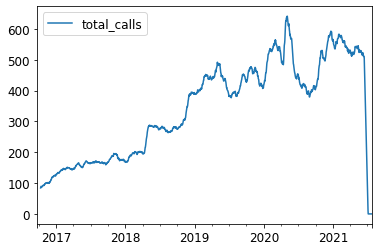

In [54]:
background_rate.rolling(21).mean().plot()

In [86]:
response_df = combined_df.groupby('first_live_camera').apply(lambda df: get_normalized_time_series(df, background_rate)).reset_index().dropna()

<AxesSubplot:>

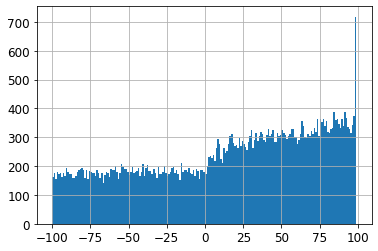

In [90]:
combined_df.days_since_live.hist(bins=np.arange(-100,100,1))

<AxesSubplot:>

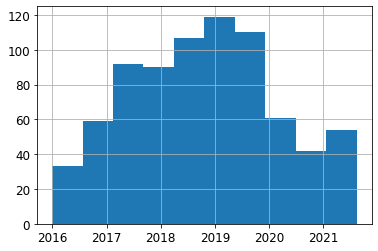

In [66]:
greenlight_geo_df.live_day.hist()

[Text(0, 0.5, 'number of greenlight locations with calls\non this relative live date')]

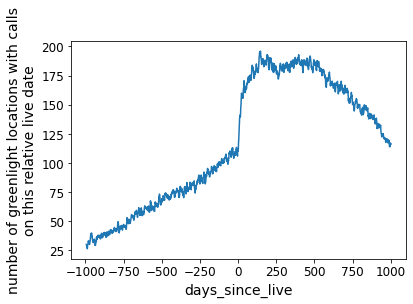

In [91]:
response_df.groupby('days_since_live').apply(lambda df: df.first_live_camera.nunique()).loc[-1000:1000].rolling(7).mean().plot()
plt.gca().set(ylabel='number of greenlight locations with calls\non this relative live date')

<AxesSubplot:xlabel='days_since_live'>

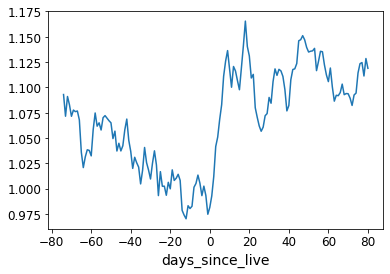

In [57]:
window = 80
(response_df.groupby('days_since_live').response.mean()).loc[-window:window].rolling(7).mean().plot()

In [105]:
df = filtered_df.loc[lambda df: df.first_live_camera==616]
df.head()

,geometry,calldescription,category,call_timestamp,call_day,first_live_camera,live_day,days_since_live
1015,POINT (-83.02136 42.36091),MENTAL NOT VIOLENT,MENTPPRS,2016-09-21 04:10:21,2016-09-21,616.0,2019-12-13,-1178.0
1595,POINT (-83.02162 42.36130),DISTURBANCE,DISTURB,2016-09-21 18:25:07,2016-09-22,616.0,2019-12-13,-1177.0
1807,POINT (-83.02162 42.36130),BURGLARY OTHER,HI3,2016-09-21 21:38:45,2016-09-22,616.0,2019-12-13,-1177.0
2728,POINT (-83.02162 42.36130),MENTAL VIOLENT NOT ARMED,MNTLNARM,2016-09-22 18:08:44,2016-09-23,616.0,2019-12-13,-1176.0
7185,POINT (-83.02162 42.36130),RAPE IP OR JH,RAPE,2016-09-26 15:14:48,2016-09-27,616.0,2019-12-13,-1172.0


In [175]:
event_proportions_normalized.to_frame().merge(df, on="call_day").set_index("days_since_live")

,call_day,response,geometry,calldescription,category,call_timestamp,first_live_camera,live_day
days_since_live,,,,,,,,
-1178.0,2016-09-21,1.942016,POINT (-83.02136 42.36091),MENTAL NOT VIOLENT,MENTPPRS,2016-09-21 04:10:21,616.0,2019-12-13
-1177.0,2016-09-22,2.543526,POINT (-83.02162 42.36130),DISTURBANCE,DISTURB,2016-09-21 18:25:07,616.0,2019-12-13
-1177.0,2016-09-22,2.543526,POINT (-83.02162 42.36130),BURGLARY OTHER,HI3,2016-09-21 21:38:45,616.0,2019-12-13
-1176.0,2016-09-23,1.318433,POINT (-83.02162 42.36130),MENTAL VIOLENT NOT ARMED,MNTLNARM,2016-09-22 18:08:44,616.0,2019-12-13
-1172.0,2016-09-27,1.796365,POINT (-83.02162 42.36130),RAPE IP OR JH,RAPE,2016-09-26 15:14:48,616.0,2019-12-13
...,...,...,...,...,...,...,...,...
547.0,2021-06-12,1.927135,POINT (-83.02162 42.36130),TRAFFIC STOP,TRF STOP,2021-06-11 23:37:14,616.0,2019-12-13
548.0,2021-06-13,0.588972,POINT (-83.02136 42.36091),SPECIAL ATTENTION,SPCL ATT,2021-06-12 15:04:14,616.0,2019-12-13
548.0,2021-06-13,0.588972,POINT (-83.02136 42.36091),DISTURBANCE,DISTURB,2021-06-13 06:40:18,616.0,2019-12-13


<AxesSubplot:xlabel='call_day'>

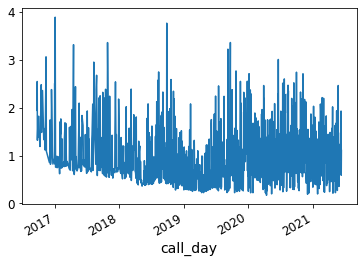

In [168]:
event_proportions_normalized.plot()

In [107]:
%matplotlib widget
df.groupby("call_day").calldescription.count().rename("n_calls").plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='call_day'>

In [115]:
event_counts = df.groupby("call_day").calldescription.count().rename("n_calls")
event_proportions = pd.merge(background_rate, event_counts, left_index=True, right_on="call_day").pipe(
    lambda df: df.n_calls / df.total_calls
)
event_proportions_normalized = (event_proportions / event_proportions.mean()).rename("response")

In [127]:
%matplotlib widget
event_proportions_normalized.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='call_day'>

In [120]:
df

,geometry,calldescription,category,call_timestamp,call_day,first_live_camera,live_day,days_since_live
1015,POINT (-83.02136 42.36091),MENTAL NOT VIOLENT,MENTPPRS,2016-09-21 04:10:21,2016-09-21,616.0,2019-12-13,-1178.0
1595,POINT (-83.02162 42.36130),DISTURBANCE,DISTURB,2016-09-21 18:25:07,2016-09-22,616.0,2019-12-13,-1177.0
1807,POINT (-83.02162 42.36130),BURGLARY OTHER,HI3,2016-09-21 21:38:45,2016-09-22,616.0,2019-12-13,-1177.0
2728,POINT (-83.02162 42.36130),MENTAL VIOLENT NOT ARMED,MNTLNARM,2016-09-22 18:08:44,2016-09-23,616.0,2019-12-13,-1176.0
7185,POINT (-83.02162 42.36130),RAPE IP OR JH,RAPE,2016-09-26 15:14:48,2016-09-27,616.0,2019-12-13,-1172.0
...,...,...,...,...,...,...,...,...
4033788,POINT (-83.02162 42.36130),TRAFFIC STOP,TRF STOP,2021-06-11 23:37:14,2021-06-12,616.0,2019-12-13,547.0
4035397,POINT (-83.02136 42.36091),SPECIAL ATTENTION,SPCL ATT,2021-06-12 15:04:14,2021-06-13,616.0,2019-12-13,548.0
4037169,POINT (-83.02136 42.36091),DISTURBANCE,DISTURB,2021-06-13 06:40:18,2021-06-13,616.0,2019-12-13,548.0
4037602,POINT (-83.02162 42.36130),SPECIAL ATTENTION,SPCL ATT,2021-06-13 13:32:34,2021-06-14,616.0,2019-12-13,549.0


In [123]:
event_proportions_normalized.loc[:'2019-12-13'].mean()

0.9424189296118196

In [124]:
event_proportions_normalized.loc['2019-12-13':].mean()

1.081267305073316

In [128]:
%matplotlib widget
event_proportions_normalized.to_frame().merge(df, on="call_day").set_index("days_since_live").response.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='days_since_live'>

In [77]:
t.loc[t.days_since_live < 0,'response'].median()

1.2554376842649921

In [78]:
t.loc[t.days_since_live > 0,'response'].median()

1.0246304288663313

In [266]:
from scipy.stats import ttest_ind

In [280]:
ttest_ind(t.loc[t.days_since_live < 0,'response'],t.loc[t.days_since_live > 0,'response'],equal_var=False)

Ttest_indResult(statistic=103.3708580226368, pvalue=0.0)

In [82]:
# combined_df.loc[lambda df: (df.calldescription.str.contains('SPECIAL ATTENTION')) & (df.days_since_live > 0),'calldescription'].value_counts()
tmp = combined_df.loc[
    lambda df: (df.days_since_live > 0), "calldescription"
].value_counts().to_frame().merge(
    combined_df.loc[
        lambda df: (df.days_since_live < 0), "calldescription"
    ].value_counts(),
    left_index=True,
    right_index=True,
    suffixes=('_after','_before')
).pipe(lambda df: df.calldescription_after/df.calldescription_before).sort_values().pipe(np.log2)

In [83]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ttt.loc[-1000:1000].plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

NameError: name 'ttt' is not defined

In [85]:
live_cameras = [(greenlight_geo_df.live_day <= x).sum() for x in date_range]
live_cameras = pd.Series(index=date_range,data=live_cameras,name='live_cameras')
live_cameras.index.name = 'call_day'
live_cameras.head(3)

call_day
2016-01-01    8
2016-01-02    8
2016-01-03    8
Freq: D, Name: live_cameras, dtype: int64

to do: assume live date is not correlated with crime in proximity of the camera, calculate average proportion of total crime by project greenlight site.

In [221]:
dff = combined_df.groupby(["call_day", "days_since_live"]).calldescription.count().to_frame(
    "ncalls"
).join(background_rate).join(live_cameras).assign(
    proportion_of_calls_per_camera=lambda df: df.ncalls
    / df.total_calls
    / df.live_cameras
).reset_index('days_since_live')
idx = dff.days_since_live < 0
dff.loc[idx ,'proportion_of_calls_per_site'] = dff.loc[idx,'ncalls'] / dff.loc[idx,'total_calls']/(dff.live_cameras.max()-dff.loc[idx,'live_cameras'])

## Approximating the relationship between lat/long distance and meters using google maps in detroit


In [227]:
# east-west
a = (42.450528328751126, -82.94340486981733)
b = (42.440174033911795, -83.27726268725615)
d = 27500

In [228]:
d/(((a[1]-b[1])**2)+((a[0]-b[0])**2))**.5

82330.80771892238

In [229]:
# diagonal across city
a = (42.32509067701311, -83.27145646434418)
b = (42.450528328751126, -82.94243716599868)
d = 30390

In [230]:
d/(((a[1]-b[1])**2)+((a[0]-b[0])**2))**.5

86305.87139935895

In [231]:
# north-south
a = (42.62486539290687, -82.94098561027067)
b = (42.334390950319325, -82.94534027745466)
d = 32260

In [232]:
d/(((a[1]-b[1])**2)+((a[0]-b[0])**2))**.5

111047.2066079001